# **Environment**

In [1]:
#show running-config
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
#Setting environment

import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# **1.Obtain data**

In [3]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
# Google Colab provides downloadable links to data from Google drive.

#Downloading Chars74K Fnt dataset
id='1Y0yA4Es0chjdVVH1BBgKRGtAe6zDigyF'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('EnglishFnt.tgz')

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/__init__.py", line 44, in autodetect
    from . import file_cache
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 41, in <module>
    "file_cach

In [5]:
!tar -xzvf "/content/EnglishFnt.tgz" -C "/content"

流式输出内容被截断，只能显示最后 5000 行内容。
English/Fnt/Sample043/img043-00095.png
English/Fnt/Sample043/img043-00096.png
English/Fnt/Sample043/img043-00097.png
English/Fnt/Sample043/img043-00098.png
English/Fnt/Sample043/img043-00099.png
English/Fnt/Sample043/img043-00100.png
English/Fnt/Sample043/img043-00101.png
English/Fnt/Sample043/img043-00102.png
English/Fnt/Sample043/img043-00103.png
English/Fnt/Sample043/img043-00104.png
English/Fnt/Sample043/img043-00105.png
English/Fnt/Sample043/img043-00106.png
English/Fnt/Sample043/img043-00108.png
English/Fnt/Sample043/img043-00109.png
English/Fnt/Sample043/img043-00110.png
English/Fnt/Sample043/img043-00111.png
English/Fnt/Sample043/img043-00112.png
English/Fnt/Sample043/img043-00113.png
English/Fnt/Sample043/img043-00114.png
English/Fnt/Sample043/img043-00115.png
English/Fnt/Sample043/img043-00116.png
English/Fnt/Sample043/img043-00117.png
English/Fnt/Sample043/img043-00118.png
English/Fnt/Sample043/img043-00119.png
English/Fnt/Sample043/img043-00120.pn

# **2.Pictue preprocessing**

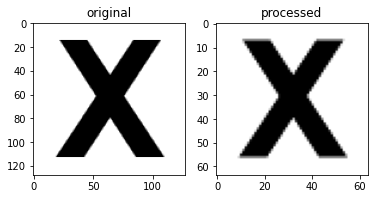

In [6]:
# Change the pixel to 64*64, read the picture 
def img_resizing(i_path):
  gray = cv2.imread(i_path,cv2.IMREAD_GRAYSCALE)#Load as a grayscale image 
  chara = cv2.resize(gray, (64,64), interpolation = cv2.INTER_CUBIC)
  return chara
imgpath = '/content/English/Fnt/Sample034/img034-00138.png'#Show a picture 
img = cv2.imread(imgpath)
re_img = img_resizing(imgpath)
plt.subplot(1,2,1)
plt.title('original')
plt.imshow(img, cmap = 'gray')

plt.subplot(1,2,2)
plt.title('processed')
plt.imshow(re_img, cmap = 'gray')

In [7]:
# Import all pictures 
whole_data = []
whole_label = []
for i in range(62):
  path = 'English/Fnt/Sample%03d/' %(i+1)
  for filename in tqdm(os.listdir(path)):
    img = img_resizing(path + filename)
    tmp = img.reshape([img.shape[0]*img.shape[1]])
    whole_data.append(np.array(tmp,dtype = "int32"))
    whole_label.append(i+1)

100%|██████████| 1016/1016 [00:00<00:00, 5584.15it/s]


In [8]:
new_data = np.array(whole_data)
new_data.shape #The dataset originally has 62,992 images 

(62992, 4096)

# **3.Stratified random sampling**

In [9]:
X = new_data/255.0#normalized
y = np.array(whole_label)
data_train,abandon_train,data_test,abandon_test = train_test_split(X,y,test_size = 916/1016, random_state = 42, stratify=y) #Layered random interception of 100 pictures of each category 
data_test.shape


(6200,)

# **4.Pre-process data(PCA)**

In [10]:
# Allocate training and test sets 
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(data_train,data_test, test_size = 1/5, random_state = 42, stratify=data_test)


In [11]:
# Perform PCA without reducing dimensionality
pca = PCA()
pca.fit(x_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)

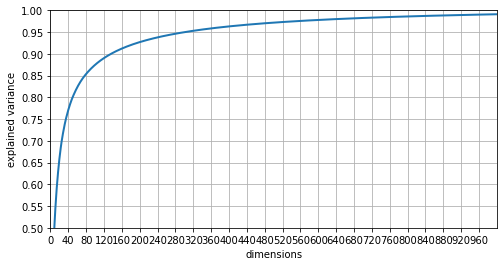

In [12]:
# Plot the explained variance vs number of dimensions
plt.figure(figsize = (8,4))
plt.plot(cumsum, linewidth=2)
plt.axis([0, 1000, 0.5, 1]) 
plt.xticks(np.arange(0, 1000, 40)) 
plt.yticks(np.arange(0.5, 1.01, 0.05)) 
plt.xlabel("dimensions")
plt.ylabel("explained variance")
plt.grid(True)
plt.show()

In [13]:
#select 90% explained variance of the data
pca = PCA(n_components=0.90).fit(x_train)#fit PCA model to the training data
#transform training data and test data onto to the selected principal components
x_train = pca.transform(x_train)
x_test = pca.transform(x_test)
print("Reduced shape of training data: {}".format(str(x_train.shape)))
print("Reduced shape of test data: {}".format(str(x_test.shape)))
#Data dimension reduced from 4096 to 139


Reduced shape of training data: (4960, 137)
Reduced shape of test data: (1240, 137)


# **5.Train the model (RF) and fine-tune hyperparameter (GridSearchCV)**

In [14]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = { 'criterion': ['entropy', 'gini']}# Create the parameter grid
print("Parameter grid:\n{}".format(param_grid))

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, return_train_score=True) # Use GridSearcCV on the training set
grid_search.fit(x_train, y_train)

print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))
print("Test set score: {:.2f}".format(grid_search.score(x_test, y_test)))# Accuracy on test set of the model with selected best parameters)

Parameter grid:
{'criterion': ['entropy', 'gini']}
Best cross-validation score: 0.73
Best parameters: {'criterion': 'gini'}
Best estimator:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Test set score: 0.75
CPU times: user 4min 37s, sys: 584 ms, total: 4min 38s
Wall time: 4min 37s


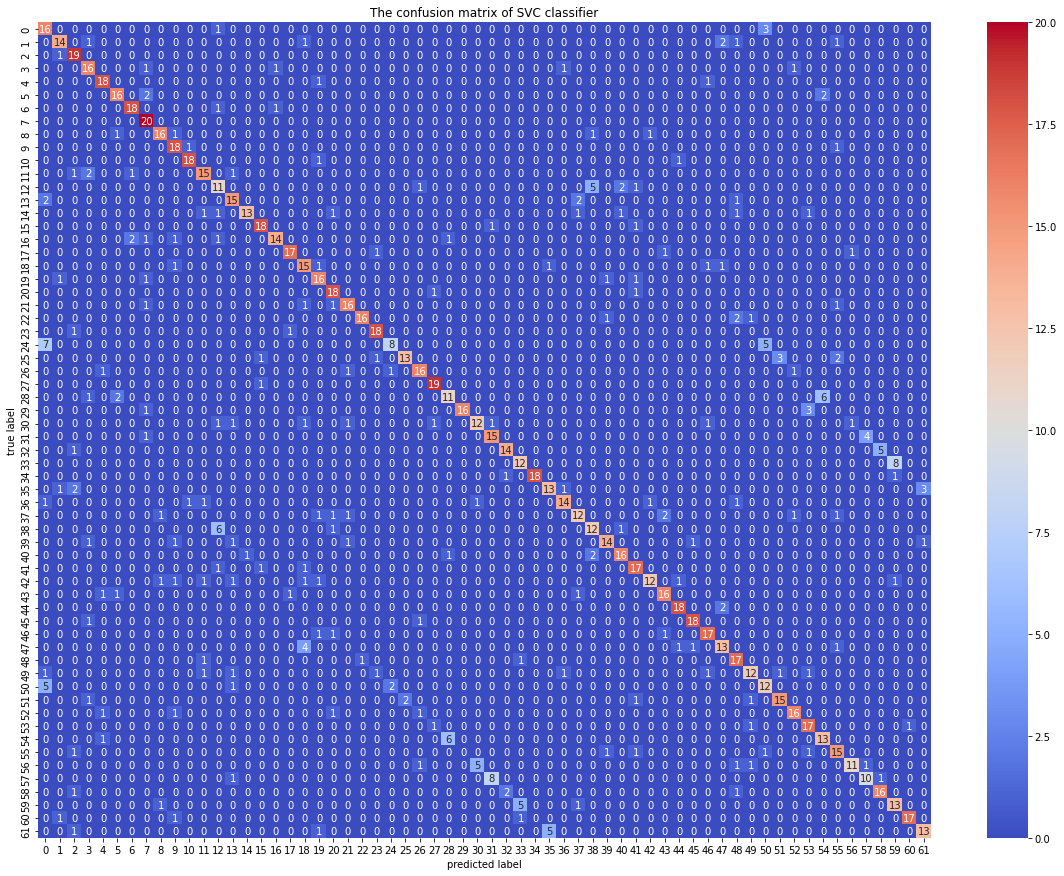

In [18]:
#Build confusion matrix 
y_test_pred = grid_search.best_estimator_.predict(x_test)#get the prediction of test set
actual = y_test
predicted = y_test_pred
plt.figure(figsize = (20,15))#Define confusion matrix size 
sns.heatmap (confusion_matrix(actual, predicted), annot=True, fmt="d",cmap="coolwarm")
plt.title("The confusion matrix of SVC classifier")
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.show(sns)